<a href="https://colab.research.google.com/github/Gedeon-m-gedus/Image_Processing/blob/master/CV_01_Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://gh.nexteinstein.org/wp-content/uploads/sites/15/2016/09/logo.jpg)

# Neural Style Transfer
In this notebook we will implement the style transfer technique from ["Image Style Transfer Using Convolutional Neural Networks" (Gatys et al., CVPR 2015)](http://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf).

The general idea is to take two images, and produce a new image that reflects the content of one but the artistic "style" of the other. We will do this by first formulating a loss function that matches the content and style of each respective image in the feature space of a deep network, and then performing gradient descent on the pixels of the image itself.

The deep network we use as a feature extractor is [SqueezeNet](https://arxiv.org/abs/1602.07360), a small model that has been trained on ImageNet.

Here's an example of the images you'll be able to produce by the end of this notebook:

![caption](http://web.eecs.umich.edu/~justincj/teaching/eecs498/example_styletransfer.png)

Note: in the original paper they used VGG19. I reproduced the same results that they got. We are using Squeeze net because it is smaller and more efiicient to use.

## Setup code
Run some setup code for this notebook: Import some useful packages

In [0]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T

import PIL
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

- We will use GPUs to accelerate our computation in this notebook. if not we will use the CPU

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

to_float_tensor = {'dtype':torch.float32, 'device':device}
dtype = torch.cuda.FloatTensor 

- Download content and few style images 

In [0]:
!wget -c https://wallpapercave.com/wp/wp6037636.jpg
!wget -c https://wallpapercave.com/wp/62tytHB.jpg
!wget -c https://cdn.thecoolist.com/wp-content/uploads/2016/05/van-gogh-starry-night-the-coolist.jpg

style_image_path = 'wp6037636.jpg'
another_style_image_path ='van-gogh-starry-night-the-coolist.jpg'
content_image_path = '62tytHB.jpg'

--2020-04-15 23:42:57--  https://wallpapercave.com/wp/wp6037636.jpg
Resolving wallpapercave.com (wallpapercave.com)... 51.79.72.220
Connecting to wallpapercave.com (wallpapercave.com)|51.79.72.220|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

--2020-04-15 23:43:01--  https://wallpapercave.com/wp/62tytHB.jpg
Resolving wallpapercave.com (wallpapercave.com)... 51.79.72.220
Connecting to wallpapercave.com (wallpapercave.com)|51.79.72.220|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

--2020-04-15 23:43:04--  https://cdn.thecoolist.com/wp-content/uploads/2016/05/van-gogh-starry-night-the-coolist.jpg
Resolving cdn.thecoolist.com (cdn.thecoolist.com)... 78.46.98.130
Connecting to cdn.thecoolist.com (cdn.thecoolist.com)|78.46.98.130|:443... connected.
HTTP request sent, awaiting respo

## Helper Functions

In [0]:
def preprocess(image, size):
  transform = T.Compose([
      T.Resize((size, size), interpolation=2),
      T.ToTensor(),
      T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])

  image = transform(image)
  image = image.unsqueeze(0)
  return image

def deprocess(img):
    transform = T.Compose([
        T.Normalize(mean=[0, 0, 0], std=[1.0 / s for s in [0.229, 0.224, 0.225]]),
        T.Normalize(mean=[-m for m in [0.485, 0.456, 0.406]], std=[1, 1, 1]),
        T.Lambda(rescale),
        T.ToPILImage(),
    ])
    return transform(img.squeeze(0))

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled


## Visulize the data

In [0]:
content_image = PIL.Image.open(content_image_path)
content_image = preprocess(content_image, size=224).to(**to_float_tensor)

style_image = PIL.Image.open(style_image_path)
style_image = preprocess(style_image, size=224).to(**to_float_tensor)

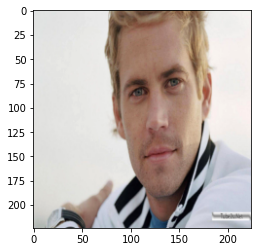

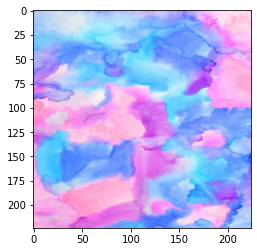

In [0]:
plt.imshow(deprocess(content_image.clone().data.cpu()))
plt.show()

plt.imshow(deprocess(style_image.clone().data.cpu()))
plt.show()

## The Model


In [0]:
# Load the pre-trained SqueezeNet model.
cnn = torchvision.models.squeezenet1_1(pretrained=True).features
cnn.type(dtype)

# We don't want to train the model any further, so we don't want PyTorch to waste computation 
# computing gradients on parameters we're never going to update.
for param in cnn.parameters():
    param.requires_grad = False

The folowing method takes an image, a model (cnn), and returns a list of feature maps, one per layer.

In [0]:
def extract_features(x, cnn):
    """
    Inputs:
    - x: A PyTorch Tensor of shape (N, C, H, W) holding a minibatch of images that
      will be fed to the CNN.
    - cnn: A PyTorch model that we will use to extract features.
    
    Returns:  A list of feature for the input images x extracted using the cnn model.
    """
    features = []
    prev_feat = x
    for i, module in enumerate(cnn._modules.values()):
        next_feat = module(prev_feat)
        features.append(next_feat)
        prev_feat = next_feat
    return features

## Computing Loss

the loss consist of three components. The loss function is a weighted sum of three terms: content loss + style loss + total variation loss.

## Content loss
We can generate an image that reflects the content of one image and the style of another by incorporating both in our loss function. We want to penalize deviations from the content of the content image and deviations from the style of the style image. We can then use this hybrid loss function to perform gradient descent **not on the parameters** of the model, but instead **on the pixel values** of our original image.

Content loss measures how much the feature map of the generated image differs from the feature map of the source image. We only care about the content representation of one layer of the network (say, layer $\ell$), that has feature maps $A^\ell \in \mathbb{R}^{1 \times C_\ell \times H_\ell \times W_\ell}$. $C_\ell$ is the number of filters/channels in layer $\ell$, $H_\ell$ and $W_\ell$ are the height and width. We will work with reshaped versions of these feature maps that combine all spatial positions into one dimension. Let $F^\ell \in \mathbb{R}^{C_\ell \times M_\ell}$ be the feature map for the current image and $P^\ell \in \mathbb{R}^{C_\ell \times M_\ell}$ be the feature map for the content source image where $M_\ell=H_\ell\times W_\ell$ is the number of elements in each feature map. Each row of $F^\ell$ or $P^\ell$ represents the vectorized activations of a particular filter, convolved over all positions of the image. Finally, let $w_c$ be the weight of the content loss term in the loss function.

Then the content loss is given by:

$L_c = w_c \times \sum_{i,j} (F_{ij}^{\ell} - P_{ij}^{\ell})^2$

In [0]:
def content_loss(content_weight, content_current, content_original):
    """
    Compute the content loss for style transfer.
    
    Inputs:
    - content_weight: Scalar giving the weighting for the content loss.
    - content_current: features of the current image; this is a PyTorch Tensor of shape
      (1, C_l, H_l, W_l).
    - content_original: features of the original image, Tensor with shape (1, C_l, H_l, W_l).
    
    Returns:
    - scalar content loss
    """
    C_c = content_current.shape[1]
    content_current = content_current.reshape(1, C_c, -1)

    C_o = content_original.shape[1]
    content_original = content_original.reshape(1, C_o, -1)

    content_loss = torch.sum((content_current - content_original )**2)
   
    return content_weight*content_loss

## Style loss
For a given layer $\ell$, the style loss is defined as follows:

First, compute the Gram matrix G which represents the correlations between the responses of each filter, where F is as above. The Gram matrix is an approximation to the covariance matrix -- we want the activation statistics of our generated image to match the activation statistics of our style image, and matching the (approximate) covariance is one way to do that. There are a variety of ways you could do this, but the Gram matrix is nice because it's easy to compute and in practice shows good results.

Given a feature map $F^\ell$ of shape $(C_\ell, M_\ell)$, the Gram matrix has shape $(C_\ell, C_\ell)$ and its elements are given by:

$$G_{ij}^\ell  = \sum_k F^{\ell}_{ik} F^{\ell}_{jk}$$

Assuming $G^\ell$ is the Gram matrix from the feature map of the current image, $A^\ell$ is the Gram Matrix from the feature map of the source style image, and $w_\ell$ a scalar weight term, then the style loss for the layer $\ell$ is simply the weighted Euclidean distance between the two Gram matrices:

$$L_s^\ell = w_\ell \sum_{i, j} \left(G^\ell_{ij} - A^\ell_{ij}\right)^2$$

In practice we usually compute the style loss at a set of layers $\mathcal{L}$ rather than just a single layer $\ell$; then the total style loss is the sum of style losses at each layer:

$$L_s = \sum_{\ell \in \mathcal{L}} L_s^\ell$$

you can read more about the intuition behind using gram matrices [here](https://www.quora.com/[here](https://)In-a-neural-style-transfer-why-does-using-Gram-matrices-keep-the-style)

In [0]:
def gram_matrix(features, normalize=True):
    """
    Compute the Gram matrix from features.
    
    Inputs:
    - features: PyTorch Tensor of shape (N, C, H, W) giving features for
      a batch of N images.
    - normalize: optional, whether to normalize the Gram matrix
        If True, divide the Gram matrix by the number of neurons (H * W * C)
    
    Returns:
    - gram: PyTorch Tensor of shape (N, C, C) giving the
      (optionally normalized) Gram matrices for the N input images.
    """
    
    N, C, H, W = features.shape    #get the shapes
    gram_matrix = torch.zeros(N, C, C, dtype=features.dtype, device=features.device)   #init

    features = features.view(N, C, -1)   
    for i in range(N):
      gram_matrix[i] = torch.mm(features[i], features[i].t())       #compute the gram matrix

    if normalize:
      gram_matrix = gram_matrix/(H*W*C)                 #Normalization step
   
    return gram_matrix

Implementation for the style loss using the gram matrices from above

In [0]:

def style_loss(feats, style_layers, style_targets, style_weights):
    """
    Computes the style loss at a set of layers.
    
    Inputs:
    - feats: list of the features at every layer of the current image, as produced by
      the extract_features function.
    - style_layers: List of layer indices into feats giving the layers to include in the
      style loss.
    - style_targets: List of the same length as style_layers, where style_targets[i] is
      a PyTorch Tensor giving the Gram matrix of the source style image computed at
      layer style_layers[i].
    - style_weights: List of the same length as style_layers, where style_weights[i]
      is a scalar giving the weight for the style loss at layer style_layers[i].
      
    Returns:
    - style_loss: A PyTorch Tensor holding a scalar giving the style loss.
    """
 
    style_loss = 0.0

    #compute the loss/layer
    for i in range(len(style_layers)):

      current_image_gram_matrix = gram_matrix(feats[style_layers[i]])
      source_image_gram_matrix = style_targets[i]

      style_loss += style_weights[i] * torch.sum((current_image_gram_matrix - source_image_gram_matrix)**2) 
 
    return style_loss

## Total-variation regularization
It turns out that it's helpful to also encourage smoothness in the image. We can do this by adding another term to our loss that penalizes wiggles or "total variation" in the pixel values. 

You can compute the "total variation" as the sum of the squares of differences in the pixel values for all pairs of pixels that are next to each other (horizontally or vertically). Here we sum the total-variation regualarization for each of the 3 input channels (RGB), and weight the total summed loss by the total variation weight, $w_t$:

$L_{tv} = w_t \times \left(\sum_{c=1}^3\sum_{i=1}^{H-1}\sum_{j=1}^{W} (x_{i+1,j,c} - x_{i,j,c})^2 + \sum_{c=1}^3\sum_{i=1}^{H}\sum_{j=1}^{W - 1} (x_{i,j+1,c} - x_{i,j,c})^2\right)$

In the next cell, fill in the definition for the TV loss term. To receive full credit, your implementation should not have any loops.

Note: this is not mentioned in the original paper but it's actually helpfull.

In [0]:
def tv_loss(img, tv_weight):
    """
    Compute total variation loss.
    
    Inputs:
    - img: PyTorch Variable of shape (1, 3, H, W) holding an input image.
    - tv_weight: Scalar giving the weight w_t to use for the TV loss.
    
    Returns:
    - loss: PyTorch Variable holding a scalar giving the total variation loss
      for img weighted by tv_weight.
    """
    tv_loss = 0.0

    _, C, H, W = img.shape
    
    #sum of the squares of differences all pixel pairs (horizontally)
    tv_loss += torch.sum((img[:, :, :, :-1] - img[:, :, :, 1:])**2) 

    #sum of the squares of differences all pixel pairs (vertically)
    tv_loss += torch.sum((img[:, :, :-1, :] - img[:, :, 1:, :])**2)

    tv_loss *= tv_weight
    
    return tv_loss

## Putting it all together

In [0]:
def style_transfer(content_image, style_image, image_size, style_size, content_layer, content_weight,
                   style_layers, style_weights, tv_weight, init_random = False):
    """
    Run style transfer!
    
    Inputs:
    - content_image: filename of content image
    - style_image: filename of style image
    - image_size: size of smallest image dimension (used for content loss and generated image)
    - style_size: size of smallest style image dimension
    - content_layer: layer to use for content loss
    - content_weight: weighting on content loss
    - style_layers: list of layers to use for style loss
    - style_weights: list of weights to use for each layer in style_layers
    - tv_weight: weight of total variation regularization term
    - init_random: initialize the starting image to uniform random noise
    """
    
    # Extract features for the content image
    content_img = preprocess(PIL.Image.open(content_image), size=image_size).type(dtype)
    feats = extract_features(content_img, cnn)
    content_target = feats[content_layer].clone()

    # Extract features for the style image
    style_img = preprocess(PIL.Image.open(style_image), size=style_size).type(dtype)
    feats = extract_features(style_img, cnn)
    style_targets = []
    for idx in style_layers:
        style_targets.append(gram_matrix(feats[idx].clone()))

    # Initialize output image to content image or noise
    if init_random:
        img = torch.Tensor(content_img.size()).uniform_(0, 1).type(dtype)
    else:
        img = content_img.clone().type(dtype)

    # We want the gradient to be computed on our image!
    img.requires_grad_()
    
    # Set up optimization hyperparameters
    initial_lr = 3.0
    decayed_lr = 0.1
    decay_lr_at = 180

    # Note that we are optimizing the pixel values of the image by passing
    # in the img Torch tensor, whose requires_grad flag is set to True
    optimizer = torch.optim.Adam([img], lr=initial_lr)
    
    for t in range(500):
        if t < 190:
            img.data.clamp_(-1.5, 1.5)
        optimizer.zero_grad()

        feats = extract_features(img, cnn)
        
        # Compute loss
        c_loss = content_loss(content_weight, feats[content_layer], content_target)
        s_loss = style_loss(feats, style_layers, style_targets, style_weights)
        t_loss = tv_loss(img, tv_weight) 
        loss = c_loss + s_loss + t_loss
        
        loss.backward()

        # Perform gradient descents on our image values
        if t == decay_lr_at:
            optimizer = torch.optim.Adam([img], lr=decayed_lr)
        optimizer.step()

        #show the results after # epochs
        if t % 100 == 0:
            print('Iteration {}'.format(t))
            plt.axis('off')
            plt.imshow(deprocess(img.data.cpu()))
            plt.show()
    print('Iteration {}'.format(t+1))
    plt.axis('off')
    plt.imshow(deprocess(img.data.cpu()))
    plt.show()

## Generation results

Try out `style_transfer` you can download an image and a style and try it out.

* The `content_image` is the filename of content image.
* The `style_image` is the filename of style image.
* The `image_size` is the size of smallest image dimension of the content image (used for content loss and generated image).
* The `style_size` is the size of smallest style image dimension.
* The `content_layer` specifies which layer to use for content loss.
* The `content_weight` gives weighting on content loss in the overall loss function. Increasing the value of this parameter will make the final image look more realistic (closer to the original content).
* `style_layers` specifies a list of which layers to use for style loss. 
* `style_weights` specifies a list of weights to use for each layer in style_layers (each of which will contribute a term to the overall style loss). We generally use higher weights for the earlier style layers because they describe more local/smaller scale features, which are more important to texture than features over larger receptive fields. In general, increasing these weights will make the resulting image look less like the original content and more distorted towards the appearance of the style image.
* `tv_weight` specifies the weighting of total variation regularization in the overall loss function. Increasing this value makes the resulting image look smoother and less jagged, at the cost of lower fidelity to style and content. 

* Note: you can play with the hyperparameters for more insights. *

Iteration 0


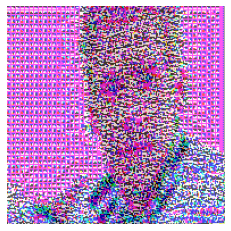

Iteration 100


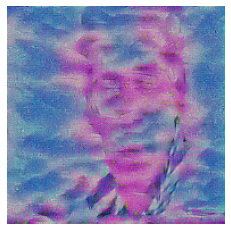

Iteration 200


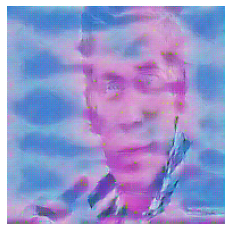

Iteration 300


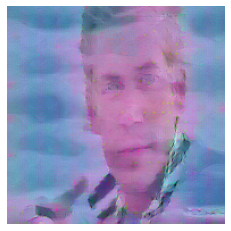

Iteration 400


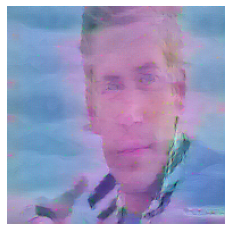

Iteration 500


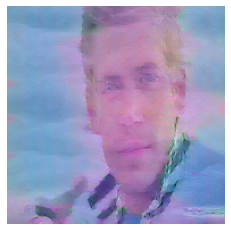

In [0]:
params = {
    'content_image':content_image_path,
    'style_image': style_image_path,
    'image_size':192,
    'style_size':224,
    'content_layer':3,
    'content_weight':3e-2,
    'style_layers':[1, 4, 6, 7],
    'style_weights':[200000, 800, 12, 1],
    'tv_weight':2e-2
}

style_transfer(**params)